In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from rpmml_project.pointmaze.point_maze_2 import MinariTrajectoryDataset, TemporalUNet, GaussianDiffusion, DiffuserTrainer, DiffuserPlanner, CompositeReward, GoalReachingReward, PathLengthPenalty, StartReachingReward
import torch

In [52]:
dataset = MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [53]:
env = dataset.dataset.recover_environment()

def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

env = unwrap_env(env)

mj_model = env.model
mj_data = env.data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = TemporalUNet(dataset.state_dim, hidden_dims=[128, 256, 512])
diffusion = GaussianDiffusion(timesteps=200)
trainer = DiffuserTrainer(model, diffusion, dataset, lr=1e-4, device=device)
trainer.load("checkpoints/diffuser_v2_epoch_100.pt")
planner = DiffuserPlanner(model, diffusion, dataset, device=device)

Using device: cuda


In [55]:
from matplotlib.patches import Rectangle
import mujoco

In [56]:
print(len(dataset))

639438


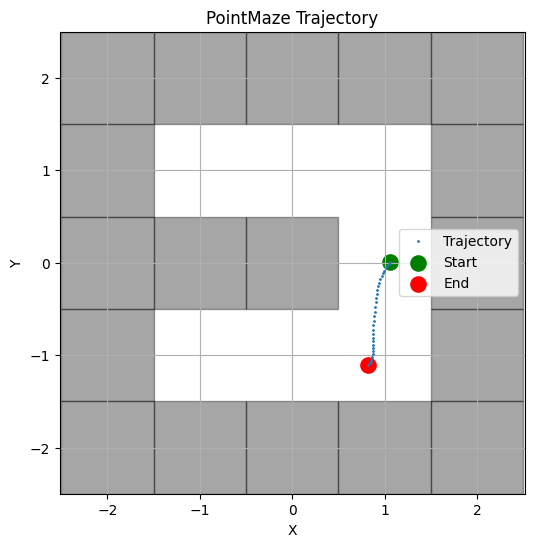

In [91]:
# Sample a trajectory window
# 32 - 325277
# 64 - 94808
idx = random.randint(0, len(dataset) - 1)
traj_norm = dataset[idx]
traj = dataset.denormalize(traj_norm).numpy()
xy = traj[:, :2]           # XY coordinates (i.e., flat outputs)

# Plot the trajectory
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy[:, 0], xy[:, 1], marker='o', linewidth=0, markersize=1, label='Trajectory')
ax.scatter(xy[0, 0], xy[0, 1], c='green', s=120, label='Start')
ax.scatter(xy[-1, 0], xy[-1, 1], c='red', s=120, label='End')

# Render MuJoCo walls
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

# Final figure styling
ax.set_title("PointMaze Trajectory")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.xlim(-2.5, +2.5)
plt.ylim(-2.5, +2.5)

# plt.show()
plt.savefig("trajectory.png")

In [92]:
idx

429010

In [93]:
current = traj[0].copy()
current[0] -= 0.4
current[1] += 0.2
goal = traj[-1, :2].copy()

In [94]:
reward_fn = CompositeReward([
    StartReachingReward(current[:2], reward_scale=5.0),  # Increased from 10
    GoalReachingReward(goal, reward_scale=5.0),          # Keep balanced
    PathLengthPenalty(reward_scale=3.0),                  # Reduced from 0.5!
])

traj_model = planner.plan(
    current, goal,
    horizon=32,
    reward_fn=reward_fn,
    guidance_scale=3.0,
    condition_on_start=False,
    condition_on_goal=False,
    conditioning_schedule="cosine",
    conditioning_strength=0.5,
)
print(f"Start (actual): {traj_model[0, :2]}")
print(f"Start (target): {current[:2]}")
print(f"Start error: {np.linalg.norm(traj_model[0, :2] - current[:2]):.4f}")
print(f"End: {traj_model[-1, :2]}")
print(f"Goal: {goal}")
print(f"Goal error: {np.linalg.norm(traj_model[-1, :2] - goal):.4f}")

# Check for discontinuities (physics violations)
diffs = np.linalg.norm(traj_model[1:, :2] - traj_model[:-1, :2], axis=1)
max_jump = diffs.max()
print(f"Max step size: {max_jump:.4f}")
if max_jump > 0.1:  # Adjust threshold based on your maze
    print("  ⚠️  WARNING: Large discontinuity detected!")
else:
    print("  ✓ Trajectory appears continuous")

Start (actual): [0.66448166 0.18464971]
Start (target): [0.66239792 0.20705416]
Start error: 0.0225
End: [ 0.82250547 -1.08170387]
Goal: [ 0.82345974 -1.10406729]
Goal error: 0.0224
Max step size: 0.0529
  ✓ Trajectory appears continuous


In [95]:
traj_model.shape

(32, 4)

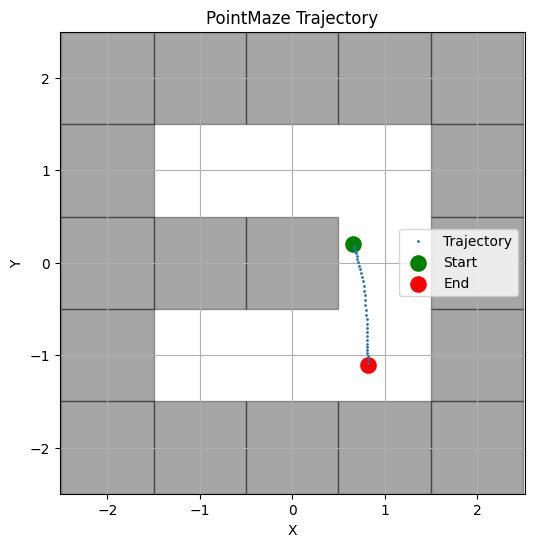

In [96]:
xy_model = traj_model[:, :2]           # XY coordinates (i.e., flat outputs)

# Plot the trajectory
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy_model[:, 0], xy_model[:, 1], marker='o', linewidth=0, markersize=1, label='Trajectory')
ax.scatter(current[0], current[1], c='green', s=120, label='Start')
ax.scatter(goal[0], goal[1], c='red', s=120, label='End')

# Render MuJoCo walls
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

# Final figure styling
ax.set_title("PointMaze Trajectory")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.xlim(-2.5, +2.5)
plt.ylim(-2.5, +2.5)

# plt.show()
plt.savefig("trajectory.png")